# Dreambooth

If you have already ran the training blocks in the past, and have saved the model to your Google Drive, you may proceed with the inference step, to generate images using the model you already created.

# Training

In [ ]:
#@title Training Setup

# remove sample data provided by Google Colab
!rm -r /content/sample_data

# download necessary files
!git clone https://github.com/rmyj/dreambooth.git

!pip install -r /content/dreambooth/requirements.txt

# download validation set - designed for Google Colab
%cd /content/
for i in range(173):
  i = i + 1
  url = f"https://github.com/rmyj/txt2img/raw/main/assets/sd-v1-4.zip.{i:03}"
  !wget $url
# concatenate all part files to one zip
!cat /content/sd-v1-4.zip* > /content/sd-v1-4.zip
!rm /content/sd-v1-4.zip.*
# repair combination
!zip -FF /content/sd-v1-4.zip --out /content/sd-v1-4-full.zip
!rm /content/sd-v1-4.zip
# unzip combination
!unzip /content/sd-v1-4-full.zip
!rm /content/sd-v1-4-full.zip

In [ ]:
#@title Upload Images
from google.colab import files
files.upload()

!mkdir /content/dreambooth/data/
!mkdir /content/dreambooth/data/subject/

!mkdir /content/dreambooth/output/

!mv /content/*.PNG /content/dreambooth/data/subject/
!mv /content/*.png /content/dreambooth/data/subject/
!mv /content/*.jpg /content/dreambooth/data/subject/

In [ ]:
#@title Train
!accelerate launch /content/dreambooth/scripts/train_dreambooth.py \
  --pretrained_model_name_or_path="/content/sd-v1-4/"  \
  --instance_data_dir="/content/dreambooth/data/subject/" \
  --output_dir="/content/dreambooth/models/output" \
  --instance_prompt="a photo of fefefefefefefe person" \
  --resolution=512 \
  --train_batch_size=1 \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=2000

In [ ]:
#@title Save
#@markdown This code block requests permission for this notebook to access your Google Drive, then zips the output folder, and moves it to your Google Drive home directory for later download. This method is by far the fastest way to download files from Google Colab, as the direct browser download takes a very long time.
#@markdown output.zip will be saved in `/content/drive/MyDrive/dreambooth/output.zip`

from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/drive/MyDrive/dreambooth

!zip -r /content/output.zip /content/dreambooth/models/output/

!mkdir /content/drive/MyDrive/dreambooth/

!rm /content/drive/MyDrive/dreambooth/output.zip

!mv /content/output.zip /content/drive/MyDrive/dreambooth/output.zip

***
# Inference

In [4]:
#@title Inference Setup

!mkdir /content/output

from PIL import Image
from diffusers import StableDiffusionPipeline
import random
import uuid
import torch

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
#@title Load
#@markdown This code block will load the model from `/content/drive/MyDrive/dreambooth/output.zip` into memory.

from google.colab import drive
drive.mount('/content/drive')

!mv /content/drive/MyDrive/dreambooth/output.zip /content/output.zip
!unzip /content/output.zip


In [7]:
#@title Load model
# set variables for inference
model_dir = "/content/content/dreambooth/models/output" #@param {type:"string"}
pipe = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float16).to("cuda")

# to disable the safety checker
pipe.safety_checker = lambda images, clip_input: (images, False)

## Generate

digital oil painting of fefefefefefefe person, ultra quality, baroque, 4k, dramatic lighting, trending on artstation-10229588840017853018


  0%|          | 0/68 [00:00<?, ?it/s]

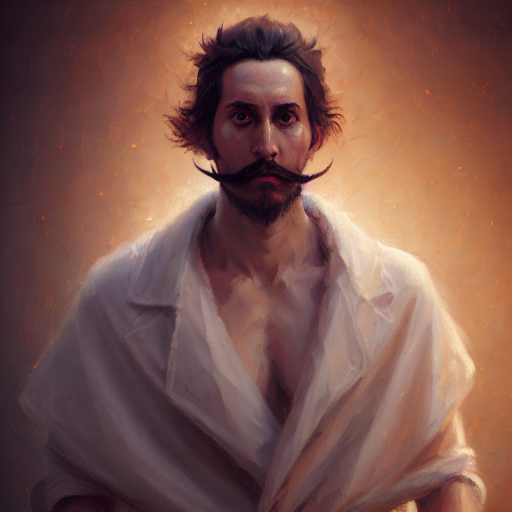

In [25]:
#@title 512x512 single image synthesis
prompt = "digital oil painting of fefefefefefefe person, ultra quality, baroque, 4k, dramatic lighting, trending on artstation"
num_inference_steps=68
guidance_scale=7.5
width=512
height=512

seed = uuid.uuid4().int & (1<<64)-1

g_cuda = torch.Generator("cuda").manual_seed(seed)

print(f"{prompt}-{seed}")
image = pipe(prompt, height=height, width=width, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
image.save(f"/content/output/{prompt}-{seed}-md.png")
image

In [ ]:
#@title Single Image Random Prompt Generation

height=512
width=512
import random
from PIL.PngImagePlugin import PngImageFile, PngInfo
middle = ["royal gardens", "garden of eden", "eden", "mandelbulb fractal", "mandelbrot set", "antimatter", "gravity", "futuristic", "robotic", "photoshopped", \
          "bright neon colors", "glacier", "glaciation", "aesthetically pleasing", "fireworks", "visually stunning", "heavenly glow", "heavenly aura", \
          "4k resolution", "8k resolution", "4k res", "8k res", "assassin's creed costume", "Thermoluminescence", "aztec god", "psychedelic rainbow magic", \
          "sunlight streaming through clouds", "wispy clouds", "long hair", "long hairstyle", "bald", "wavy hair", "this is fine meme dog", "icy", "snow", \
          "nuclear mushroom", "a million colourful balloons", "evga FTW3 RTX 3090", "rapunzel hair", "flowers in hair", "macaw", "knightly armour", "shoe on head", \
          "book on head", "high-key", "longest moustache in the world", "casting a spell", "in varrock", "in lumbridge", "with a fire staff", "shoe on head", \
          "colourful bowtie", "colourful scarf", "colourful party hat", "osrs party hat", "runescape party hat", "rune scimitar", "osrs graphics", "2007scape", \
          "old master", "old masters", "louvre collection", "museum collection", "traditional chinese wedding dress", "Todos Santos Cuchumatán", "wearing Sari", \
          "wearing gho", "Conical hat", "Sardinian traditional dress", "keffiyeh", "shemagh" ,"ghutrah", "colourful traditional clothing", \
          "wearing long royal robe", "sequins", "academic", "jeweled", "detailed face", "fashion photography", "male model", "shallow depth of field", \
          "morrowind", "beautiful composition", "chin-strap facial hair", "colourful facial hair", "colourful hair", "painting in museum", "sharp focus", \
          "realistic", "intricate", "octane render", "trending artstation", "monochrome", "extreme detail", "Utrecht Caravaggism", "on a magic carpet", \
          "on horseback", "glitter", "neon lights", "long hair", "inferno", "vivid colors", "mycelium", "colourful smoke", "colourful clouds", \
          "quantum physics", "rembrandt lighting", "tesla coil", "plasma", "happy accidents", "tekken character", "street fighter character", \
          "atari graphics", "tempera", "Ukiyo-e", "cumulus", "portrait", "being fed grapes", "looking at camera", "isometric view", "full body", \
          "from behind", "aerial shot", "bird's eye shot", "😂", "❤️", "🤣", "🔥", "😍", "🥰", "🙏", "✨", "🔞💦🍆😳👄🍑🚿😈👅", "World Heritage Site", \
          "sunbeam", "crepuscular rays", "god rays", "asperitas clouds", "かわいい", "oneshota", "Dungeons & Dragons", "patronus", "Lovecraftian", "daguerreotype", \
          "Gorillaz", "prismatic", "bokeh", "raining", "far from camera", "vibrant", "epic", "volumetric lighting", "jellyfish from finding nemo", "disney", "pixar", \
          "3D render", "boutonnière", "balloons from UP", "HDR", "holi", "turban", "with a thousand arms", "mushroom helmet", "reflection", "transparent", \
          "british explorers", "smoking a cigar", "drinking a cocktail", "summoning a taxi", "german traditional dress", "santa hat", "noita", "Cel Shaded", \
          "Margit, the Fell Omen", "Morgott, the Omen King", "bandholz beard", "Rennala, Queen of the Full Moon", "elden beast", "elden ring", "fel fire", \
          "blue fire", "smooth", "taniwha", "surrounded by sheep", "Silver fern", "tui", "wood pigeon", "kereru", "pounamu", "kiwiana", "pohutawaka", \
          "kowhai", "surrounded by new zealand birds", "surrounded by new zealand bush", "surrounded by clouds", "sharp focus", "Picasso's African Period", \
          "Picasso's Blue Period", "fine art", "bladerunner", "baroque element", "baroque elements", "complimentry colours", "river", "surrounded by butterflies", \
          "surrounded by flowers", "unreal engine 5", "lightsaber", "hacker", "bowtie", "Barong", "balinese mask", "tribal mask", "african mask", \
          "award winning photography", "award winning", "deviantart", "surrounded by ice", "frozen", "divine", "surrounded by clifford the big red dog", \
          "monocle", "top hat", "meme", "kimono", "Windsor glasses", "surrounded by bunnies", "surrounded by piglets", "surrounded by pandas", \
          "surrounded by frogs", "blindfolded", "gold chain", "bling", "surrounded by puppies", "surrounded by dogs", "surrounded by kittens", \
          "surrounded by cats", "LSD visuals", "DMT fractal patterns", "ornate", "hallucinogen", "mutagen", "mutated", "coronation robes 1701", \
          "masterpiece", "fu manchu moustache", "star-burns", "muttonchops", "captain hook moustache", "salvador dali moustache", "animorphs", \
          "on fire", "barbaric", "hyper detailed", "ultra sharp", "sunny", "overwatch character", "highly detailed", "detailed face", "papakha hat", \
          "papakha woolen hat", "tamoko", "cinematic lighting", "golden", "rich", "exotic", "spicy", "fruity", "yoked", "jacked", "holy", "royal", \
          "bearded", "neon", "waterfall", "whirlpool", "electric", "cyberpunk", "futuristic", "pink", "opal", "iridescent", "vibrant", "high society", \
          "artistic", "artstation", "rainbow supernova", "masculine", "rule of thirds", "beautiful", "8k", "4k", "hooded cloak", "glowing", "french moustache", \
          "viking beard", "handlebar moustache", "imperial beard", "Ultra realistic", "heavy brushstrokes", "crisp", "sharp", "ultra sharp", "high resolution", \
          "breathtaking", "trending on artstation", "bioluminous", "funky", "medusa", "supernova", "nebula", "AI", "vibrant", "white dreadlocks", "rainbow", \
          "cotton candy", "popcorn", "coral reef", "tropical fish", "fish and chips", "foehn wall cloud"]

prompts = []
prompts.append("oil painting of (sks person), large french moustache, heavy brushstrokes, dramatic lighting, very detailed, insane detail, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, surrounded by exploding nebula, dramatic lighting, very detailed, insanely detailed, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, surrounded by exploding nebula, interdimensional, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, whirlpool, surrounded by exploding nebula, interdimensional, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, whirlpool, surrounded by exploding nebula, pink, interdimensional, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, surrounded by exploding nebula, angelic, gates of heaven, interdimensional, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, surrounded by exploding nebula, demonic, gates of hell, interdimensional, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, surrounded by heaven and hell, interdimensional portal, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting portrait of sks person, french moustache, heavy brushstrokes, beautiful eyes, whirlpool, surrounded by exploding nebula, interdimensional, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting portrait of sks person, french moustache, surrounded by colorful puppies, colorful blazer, beautiful brown eyes, heavy brushstrokes, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")
prompts.append("oil painting portrait of sks person, french moustache, surrounded by colorful cows, colorful blazer, beautiful brown eyes, heavy brushstrokes, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski")

while True:
    # can set seed here
    seed = uuid.uuid4().int & (1<<64)-1
    g_cuda = torch.Generator("cuda").manual_seed(seed)
    
    prompt = "Hello world!"

    temp = random.randint(0, 3)
    if temp == 0:
        prompt = prompts[random.randint(0, len(prompts) - 1)]
    elif temp == 1:
        animals = ["pandas", "frogs", "fireflies", "kittens", "puppies", "parrots", "bunnies", "tropical fish"]
        prompt =  "oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, surrounded by " + animals[random.randint(0, len(animals) - 1)] + ", interdimensional portal, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski"
    elif temp == 2:
        jobs = ["a chef", "a wizard", "a paladin", "a pianist", "a pilot"]
        prompt = "oil painting, portrait of sks person as " + jobs[random.randint(0 , len(jobs) - 1)] + ", heavy brushstrokes, beautiful eyes, dramatic lighting, very detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski"
    else:
        prompt = "oil painting of sks person, french moustache, heavy brushstrokes, beautiful eyes, "
        for _ in range(random.randint(1, 3)):
            prompt = prompt + middle[random.randint(0, len(middle) - 1)] + ", "
        prompt = prompt + "dramatic lighting, insanely detailed, intricate, trending on artstation, 4k, craig mullins, greg rutkowski"                       
    
    num_inference_steps=49
        
    print(f"{prompt}-{seed}")
    guidance_scale=7.5
    image = pipe(prompt, height=height, width=width, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=g_cuda).images[0]
    
    metadata = PngInfo()
    metadata.add_text("height", str(height))
    metadata.add_text("width", str(width))
    metadata.add_text("num_inference_steps", str(num_inference_steps))
    metadata.add_text("guidance_scale", str(guidance_scale))
    metadata.add_text("prompt", prompt)
    #metadata.add_text("model_id", model_id)
    metadata.add_text("seed", str(seed))
    
    file_name = f"{uuid.uuid4().int & (1<<64)-1}"
    image.save(f"/content/output/{file_name}.png", pnginfo=metadata)
    targetImage = PngImageFile(f"/content/output/{file_name}.png")
    print(f"saved to /content/output/{file_name}.png")
    #print("with metadata:", targetImage.text)
    print()

